In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_CCE_4_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:21 - loss: 2.3635 - STD: 0.0973 - MAE: 0.2243

 15/773 [..............................] - ETA: 2s - loss: 1.4742 - STD: 0.1878 - MAE: 0.1515   

 30/773 [>.............................] - ETA: 2s - loss: 1.3970 - STD: 0.1923 - MAE: 0.1472

 46/773 [>.............................] - ETA: 2s - loss: 1.3696 - STD: 0.1927 - MAE: 0.1462

 62/773 [=>............................] - ETA: 2s - loss: 1.3586 - STD: 0.1916 - MAE: 0.1464

 78/773 [==>...........................] - ETA: 2s - loss: 1.3488 - STD: 0.1920 - MAE: 0.1460

 94/773 [==>...........................] - ETA: 2s - loss: 1.3400 - STD: 0.1921 - MAE: 0.1457

110/773 [===>..........................] - ETA: 2s - loss: 1.3344 - STD: 0.1924 - MAE: 0.1453

126/773 [===>..........................] - ETA: 2s - loss: 1.3293 - STD: 0.1923 - MAE: 0.1452

130/773 [====>.........................] - ETA: 4s - loss: 1.3267 - STD: 0.1922 - MAE: 0.1451

146/773 [====>.........................] - ETA: 4s - loss: 1.3209 - STD: 0.1925 - MAE: 0.1448

162/773 [=====>........................] - ETA: 4s - loss: 1.3115 - STD: 0.1930 - MAE: 0.1443

180/773 [=====>........................] - ETA: 3s - loss: 1.2992 - STD: 0.1938 - MAE: 0.1435

198/773 [======>.......................] - ETA: 3s - loss: 1.2873 - STD: 0.1947 - MAE: 0.1428

216/773 [=======>......................] - ETA: 3s - loss: 1.2766 - STD: 0.1950 - MAE: 0.1424

233/773 [========>.....................] - ETA: 3s - loss: 1.2664 - STD: 0.1956 - MAE: 0.1419

249/773 [========>.....................] - ETA: 2s - loss: 1.2556 - STD: 0.1961 - MAE: 0.1413

265/773 [=========>....................] - ETA: 2s - loss: 1.2434 - STD: 0.1968 - MAE: 0.1406

281/773 [=========>....................] - ETA: 2s - loss: 1.2325 - STD: 0.1976 - MAE: 0.1400

298/773 [==========>...................] - ETA: 2s - loss: 1.2215 - STD: 0.1984 - MAE: 0.1393

315/773 [===========>..................] - ETA: 2s - loss: 1.2106 - STD: 0.1992 - MAE: 0.1386

332/773 [===========>..................] - ETA: 2s - loss: 1.2004 - STD: 0.2000 - MAE: 0.1379

348/773 [============>.................] - ETA: 2s - loss: 1.1904 - STD: 0.2007 - MAE: 0.1373

364/773 [=============>................] - ETA: 1s - loss: 1.1811 - STD: 0.2015 - MAE: 0.1366

380/773 [=============>................] - ETA: 1s - loss: 1.1716 - STD: 0.2022 - MAE: 0.1360

396/773 [==============>...............] - ETA: 1s - loss: 1.1620 - STD: 0.2029 - MAE: 0.1353

413/773 [===============>..............] - ETA: 1s - loss: 1.1524 - STD: 0.2037 - MAE: 0.1346

429/773 [===============>..............] - ETA: 1s - loss: 1.1430 - STD: 0.2045 - MAE: 0.1340

446/773 [================>.............] - ETA: 1s - loss: 1.1341 - STD: 0.2053 - MAE: 0.1333

462/773 [================>.............] - ETA: 1s - loss: 1.1262 - STD: 0.2060 - MAE: 0.1327

479/773 [=================>............] - ETA: 1s - loss: 1.1191 - STD: 0.2066 - MAE: 0.1322

495/773 [==================>...........] - ETA: 1s - loss: 1.1121 - STD: 0.2072 - MAE: 0.1317

512/773 [==================>...........] - ETA: 1s - loss: 1.1043 - STD: 0.2079 - MAE: 0.1310

527/773 [===================>..........] - ETA: 1s - loss: 1.0979 - STD: 0.2085 - MAE: 0.1305

543/773 [====================>.........] - ETA: 0s - loss: 1.0920 - STD: 0.2091 - MAE: 0.1301

558/773 [====================>.........] - ETA: 0s - loss: 1.0862 - STD: 0.2096 - MAE: 0.1297

572/773 [=====================>........] - ETA: 0s - loss: 1.0810 - STD: 0.2100 - MAE: 0.1292

588/773 [=====================>........] - ETA: 0s - loss: 1.0751 - STD: 0.2106 - MAE: 0.1288

604/773 [======================>.......] - ETA: 0s - loss: 1.0691 - STD: 0.2112 - MAE: 0.1283

620/773 [=======================>......] - ETA: 0s - loss: 1.0638 - STD: 0.2117 - MAE: 0.1278

637/773 [=======================>......] - ETA: 0s - loss: 1.0587 - STD: 0.2121 - MAE: 0.1274

653/773 [========================>.....] - ETA: 0s - loss: 1.0542 - STD: 0.2126 - MAE: 0.1271

670/773 [=========================>....] - ETA: 0s - loss: 1.0491 - STD: 0.2131 - MAE: 0.1267

687/773 [=========================>....] - ETA: 0s - loss: 1.0444 - STD: 0.2135 - MAE: 0.1263

704/773 [==========================>...] - ETA: 0s - loss: 1.0393 - STD: 0.2140 - MAE: 0.1259

719/773 [==========================>...] - ETA: 0s - loss: 1.0359 - STD: 0.2143 - MAE: 0.1256

735/773 [===========================>..] - ETA: 0s - loss: 1.0321 - STD: 0.2147 - MAE: 0.1253

752/773 [============================>.] - ETA: 0s - loss: 1.0281 - STD: 0.2151 - MAE: 0.1250

769/773 [============================>.] - ETA: 0s - loss: 1.0240 - STD: 0.2155 - MAE: 0.1247

773/773 [==============================] - 5s 5ms/step - loss: 1.0231 - STD: 0.2155 - MAE: 0.1246 - val_loss: 0.8523 - val_STD: 0.2450 - val_MAE: 0.1019


Epoch 2/10000


  1/773 [..............................] - ETA: 17s - loss: 0.7662 - STD: 0.2497 - MAE: 0.0963

 16/773 [..............................] - ETA: 2s - loss: 0.8374 - STD: 0.2337 - MAE: 0.1091 

 33/773 [>.............................] - ETA: 2s - loss: 0.8369 - STD: 0.2341 - MAE: 0.1089

 50/773 [>.............................] - ETA: 2s - loss: 0.8372 - STD: 0.2337 - MAE: 0.1091

 67/773 [=>............................] - ETA: 2s - loss: 0.8367 - STD: 0.2339 - MAE: 0.1090

 85/773 [==>...........................] - ETA: 2s - loss: 0.8361 - STD: 0.2339 - MAE: 0.1089

102/773 [==>...........................] - ETA: 2s - loss: 0.8395 - STD: 0.2336 - MAE: 0.1093

116/773 [===>..........................] - ETA: 2s - loss: 0.8378 - STD: 0.2336 - MAE: 0.1092

133/773 [====>.........................] - ETA: 2s - loss: 0.8376 - STD: 0.2337 - MAE: 0.1091

149/773 [====>.........................] - ETA: 1s - loss: 0.8363 - STD: 0.2339 - MAE: 0.1090

165/773 [=====>........................] - ETA: 1s - loss: 0.8343 - STD: 0.2340 - MAE: 0.1088

181/773 [======>.......................] - ETA: 1s - loss: 0.8335 - STD: 0.2341 - MAE: 0.1088

197/773 [======>.......................] - ETA: 1s - loss: 0.8328 - STD: 0.2342 - MAE: 0.1087

213/773 [=======>......................] - ETA: 1s - loss: 0.8322 - STD: 0.2342 - MAE: 0.1087

229/773 [=======>......................] - ETA: 1s - loss: 0.8312 - STD: 0.2344 - MAE: 0.1085

245/773 [========>.....................] - ETA: 1s - loss: 0.8309 - STD: 0.2345 - MAE: 0.1085

261/773 [=========>....................] - ETA: 1s - loss: 0.8301 - STD: 0.2345 - MAE: 0.1084

276/773 [=========>....................] - ETA: 1s - loss: 0.8286 - STD: 0.2347 - MAE: 0.1083

292/773 [==========>...................] - ETA: 1s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1082

308/773 [==========>...................] - ETA: 1s - loss: 0.8264 - STD: 0.2349 - MAE: 0.1081

324/773 [===========>..................] - ETA: 1s - loss: 0.8250 - STD: 0.2350 - MAE: 0.1080

340/773 [============>.................] - ETA: 1s - loss: 0.8240 - STD: 0.2350 - MAE: 0.1079

356/773 [============>.................] - ETA: 1s - loss: 0.8232 - STD: 0.2352 - MAE: 0.1078

373/773 [=============>................] - ETA: 1s - loss: 0.8220 - STD: 0.2353 - MAE: 0.1077

389/773 [==============>...............] - ETA: 1s - loss: 0.8218 - STD: 0.2353 - MAE: 0.1077

405/773 [==============>...............] - ETA: 1s - loss: 0.8210 - STD: 0.2353 - MAE: 0.1076

421/773 [===============>..............] - ETA: 1s - loss: 0.8202 - STD: 0.2354 - MAE: 0.1075

434/773 [===============>..............] - ETA: 1s - loss: 0.8195 - STD: 0.2355 - MAE: 0.1075

446/773 [================>.............] - ETA: 1s - loss: 0.8190 - STD: 0.2356 - MAE: 0.1074

458/773 [================>.............] - ETA: 1s - loss: 0.8182 - STD: 0.2356 - MAE: 0.1074

470/773 [=================>............] - ETA: 1s - loss: 0.8179 - STD: 0.2357 - MAE: 0.1073

483/773 [=================>............] - ETA: 0s - loss: 0.8173 - STD: 0.2357 - MAE: 0.1073

496/773 [==================>...........] - ETA: 0s - loss: 0.8166 - STD: 0.2358 - MAE: 0.1072

509/773 [==================>...........] - ETA: 0s - loss: 0.8157 - STD: 0.2359 - MAE: 0.1071

521/773 [===================>..........] - ETA: 0s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1071

533/773 [===================>..........] - ETA: 0s - loss: 0.8144 - STD: 0.2360 - MAE: 0.1070

546/773 [====================>.........] - ETA: 0s - loss: 0.8137 - STD: 0.2360 - MAE: 0.1070

562/773 [====================>.........] - ETA: 0s - loss: 0.8127 - STD: 0.2361 - MAE: 0.1069

574/773 [=====================>........] - ETA: 0s - loss: 0.8123 - STD: 0.2362 - MAE: 0.1068

588/773 [=====================>........] - ETA: 0s - loss: 0.8114 - STD: 0.2362 - MAE: 0.1068

605/773 [======================>.......] - ETA: 0s - loss: 0.8103 - STD: 0.2364 - MAE: 0.1067

621/773 [=======================>......] - ETA: 0s - loss: 0.8094 - STD: 0.2364 - MAE: 0.1066

638/773 [=======================>......] - ETA: 0s - loss: 0.8087 - STD: 0.2365 - MAE: 0.1065

655/773 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2366 - MAE: 0.1065

672/773 [=========================>....] - ETA: 0s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1064

689/773 [=========================>....] - ETA: 0s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1063

706/773 [==========================>...] - ETA: 0s - loss: 0.8054 - STD: 0.2369 - MAE: 0.1062

722/773 [===========================>..] - ETA: 0s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1061

738/773 [===========================>..] - ETA: 0s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1061

754/773 [============================>.] - ETA: 0s - loss: 0.8030 - STD: 0.2371 - MAE: 0.1060

771/773 [============================>.] - ETA: 0s - loss: 0.8021 - STD: 0.2372 - MAE: 0.1059

773/773 [==============================] - 3s 4ms/step - loss: 0.8020 - STD: 0.2372 - MAE: 0.1059 - val_loss: 0.7709 - val_STD: 0.2490 - val_MAE: 0.0973


Epoch 3/10000


  1/773 [..............................] - ETA: 17s - loss: 0.7576 - STD: 0.2479 - MAE: 0.0972

 15/773 [..............................] - ETA: 2s - loss: 0.7795 - STD: 0.2410 - MAE: 0.1034 

 31/773 [>.............................] - ETA: 2s - loss: 0.7721 - STD: 0.2400 - MAE: 0.1034

 48/773 [>.............................] - ETA: 2s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1027

 65/773 [=>............................] - ETA: 2s - loss: 0.7638 - STD: 0.2408 - MAE: 0.1026

 81/773 [==>...........................] - ETA: 2s - loss: 0.7638 - STD: 0.2409 - MAE: 0.1025

 98/773 [==>...........................] - ETA: 2s - loss: 0.7642 - STD: 0.2410 - MAE: 0.1025

114/773 [===>..........................] - ETA: 2s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1026

130/773 [====>.........................] - ETA: 2s - loss: 0.7613 - STD: 0.2410 - MAE: 0.1023

146/773 [====>.........................] - ETA: 2s - loss: 0.7620 - STD: 0.2411 - MAE: 0.1023

162/773 [=====>........................] - ETA: 1s - loss: 0.7611 - STD: 0.2410 - MAE: 0.1023

174/773 [=====>........................] - ETA: 1s - loss: 0.7597 - STD: 0.2412 - MAE: 0.1021

186/773 [======>.......................] - ETA: 1s - loss: 0.7584 - STD: 0.2413 - MAE: 0.1020

199/773 [======>.......................] - ETA: 1s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1020

214/773 [=======>......................] - ETA: 1s - loss: 0.7585 - STD: 0.2414 - MAE: 0.1020

227/773 [=======>......................] - ETA: 1s - loss: 0.7598 - STD: 0.2413 - MAE: 0.1021

239/773 [========>.....................] - ETA: 1s - loss: 0.7590 - STD: 0.2414 - MAE: 0.1020

251/773 [========>.....................] - ETA: 1s - loss: 0.7582 - STD: 0.2415 - MAE: 0.1020

264/773 [=========>....................] - ETA: 1s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1019

278/773 [=========>....................] - ETA: 1s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1019

291/773 [==========>...................] - ETA: 1s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1019

306/773 [==========>...................] - ETA: 1s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1018

318/773 [===========>..................] - ETA: 1s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1018

330/773 [===========>..................] - ETA: 1s - loss: 0.7558 - STD: 0.2417 - MAE: 0.1017

343/773 [============>.................] - ETA: 1s - loss: 0.7553 - STD: 0.2417 - MAE: 0.1016

356/773 [============>.................] - ETA: 1s - loss: 0.7548 - STD: 0.2418 - MAE: 0.1016

368/773 [=============>................] - ETA: 1s - loss: 0.7542 - STD: 0.2419 - MAE: 0.1015

381/773 [=============>................] - ETA: 1s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1015

394/773 [==============>...............] - ETA: 1s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1014

408/773 [==============>...............] - ETA: 1s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1014

421/773 [===============>..............] - ETA: 1s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1014

434/773 [===============>..............] - ETA: 1s - loss: 0.7534 - STD: 0.2420 - MAE: 0.1014

447/773 [================>.............] - ETA: 1s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1014

460/773 [================>.............] - ETA: 1s - loss: 0.7539 - STD: 0.2420 - MAE: 0.1014

473/773 [=================>............] - ETA: 1s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1015

486/773 [=================>............] - ETA: 1s - loss: 0.7536 - STD: 0.2420 - MAE: 0.1014

499/773 [==================>...........] - ETA: 1s - loss: 0.7535 - STD: 0.2421 - MAE: 0.1014

512/773 [==================>...........] - ETA: 0s - loss: 0.7537 - STD: 0.2421 - MAE: 0.1014

525/773 [===================>..........] - ETA: 0s - loss: 0.7536 - STD: 0.2421 - MAE: 0.1014

538/773 [===================>..........] - ETA: 0s - loss: 0.7533 - STD: 0.2421 - MAE: 0.1014

551/773 [====================>.........] - ETA: 0s - loss: 0.7530 - STD: 0.2421 - MAE: 0.1013

565/773 [====================>.........] - ETA: 0s - loss: 0.7530 - STD: 0.2421 - MAE: 0.1013

579/773 [=====================>........] - ETA: 0s - loss: 0.7527 - STD: 0.2421 - MAE: 0.1013

592/773 [=====================>........] - ETA: 0s - loss: 0.7520 - STD: 0.2422 - MAE: 0.1013

605/773 [======================>.......] - ETA: 0s - loss: 0.7517 - STD: 0.2422 - MAE: 0.1012

618/773 [======================>.......] - ETA: 0s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1012

633/773 [=======================>......] - ETA: 0s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1012

646/773 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2423 - MAE: 0.1011

659/773 [========================>.....] - ETA: 0s - loss: 0.7499 - STD: 0.2424 - MAE: 0.1011

671/773 [=========================>....] - ETA: 0s - loss: 0.7496 - STD: 0.2424 - MAE: 0.1010

683/773 [=========================>....] - ETA: 0s - loss: 0.7493 - STD: 0.2424 - MAE: 0.1010

697/773 [==========================>...] - ETA: 0s - loss: 0.7489 - STD: 0.2425 - MAE: 0.1009

714/773 [==========================>...] - ETA: 0s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1009

731/773 [===========================>..] - ETA: 0s - loss: 0.7480 - STD: 0.2425 - MAE: 0.1009

747/773 [===========================>..] - ETA: 0s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1009

763/773 [============================>.] - ETA: 0s - loss: 0.7474 - STD: 0.2426 - MAE: 0.1008

773/773 [==============================] - 3s 4ms/step - loss: 0.7474 - STD: 0.2426 - MAE: 0.1008 - val_loss: 0.7691 - val_STD: 0.2433 - val_MAE: 0.0991


Epoch 4/10000


  1/773 [..............................] - ETA: 16s - loss: 0.7458 - STD: 0.2442 - MAE: 0.0998

 13/773 [..............................] - ETA: 3s - loss: 0.7398 - STD: 0.2447 - MAE: 0.0995 

 25/773 [..............................] - ETA: 3s - loss: 0.7344 - STD: 0.2446 - MAE: 0.0994

 37/773 [>.............................] - ETA: 3s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0995

 49/773 [>.............................] - ETA: 3s - loss: 0.7268 - STD: 0.2441 - MAE: 0.0991

 63/773 [=>............................] - ETA: 3s - loss: 0.7227 - STD: 0.2448 - MAE: 0.0985

 77/773 [=>............................] - ETA: 2s - loss: 0.7251 - STD: 0.2447 - MAE: 0.0987

 89/773 [==>...........................] - ETA: 2s - loss: 0.7237 - STD: 0.2448 - MAE: 0.0986

102/773 [==>...........................] - ETA: 2s - loss: 0.7246 - STD: 0.2446 - MAE: 0.0988

115/773 [===>..........................] - ETA: 2s - loss: 0.7259 - STD: 0.2446 - MAE: 0.0988

129/773 [====>.........................] - ETA: 2s - loss: 0.7256 - STD: 0.2448 - MAE: 0.0987

143/773 [====>.........................] - ETA: 2s - loss: 0.7254 - STD: 0.2448 - MAE: 0.0987

155/773 [=====>........................] - ETA: 2s - loss: 0.7253 - STD: 0.2448 - MAE: 0.0987

170/773 [=====>........................] - ETA: 2s - loss: 0.7239 - STD: 0.2448 - MAE: 0.0986

184/773 [======>.......................] - ETA: 2s - loss: 0.7237 - STD: 0.2448 - MAE: 0.0986

196/773 [======>.......................] - ETA: 2s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0987

210/773 [=======>......................] - ETA: 2s - loss: 0.7238 - STD: 0.2448 - MAE: 0.0987

223/773 [=======>......................] - ETA: 2s - loss: 0.7251 - STD: 0.2447 - MAE: 0.0988

235/773 [========>.....................] - ETA: 2s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0987

247/773 [========>.....................] - ETA: 2s - loss: 0.7249 - STD: 0.2448 - MAE: 0.0988

259/773 [=========>....................] - ETA: 2s - loss: 0.7253 - STD: 0.2447 - MAE: 0.0988

272/773 [=========>....................] - ETA: 2s - loss: 0.7246 - STD: 0.2447 - MAE: 0.0988

284/773 [==========>...................] - ETA: 1s - loss: 0.7241 - STD: 0.2447 - MAE: 0.0988

296/773 [==========>...................] - ETA: 1s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0987

309/773 [==========>...................] - ETA: 1s - loss: 0.7239 - STD: 0.2447 - MAE: 0.0987

324/773 [===========>..................] - ETA: 1s - loss: 0.7239 - STD: 0.2448 - MAE: 0.0987

336/773 [============>.................] - ETA: 1s - loss: 0.7236 - STD: 0.2448 - MAE: 0.0987

348/773 [============>.................] - ETA: 1s - loss: 0.7236 - STD: 0.2448 - MAE: 0.0986

360/773 [============>.................] - ETA: 1s - loss: 0.7235 - STD: 0.2449 - MAE: 0.0986

373/773 [=============>................] - ETA: 1s - loss: 0.7231 - STD: 0.2449 - MAE: 0.0986

386/773 [=============>................] - ETA: 1s - loss: 0.7228 - STD: 0.2450 - MAE: 0.0985

399/773 [==============>...............] - ETA: 1s - loss: 0.7228 - STD: 0.2449 - MAE: 0.0985

411/773 [==============>...............] - ETA: 1s - loss: 0.7227 - STD: 0.2450 - MAE: 0.0985

423/773 [===============>..............] - ETA: 1s - loss: 0.7225 - STD: 0.2450 - MAE: 0.0985

436/773 [===============>..............] - ETA: 1s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0985

449/773 [================>.............] - ETA: 1s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0985

465/773 [=================>............] - ETA: 1s - loss: 0.7223 - STD: 0.2450 - MAE: 0.0985

477/773 [=================>............] - ETA: 1s - loss: 0.7219 - STD: 0.2451 - MAE: 0.0984

492/773 [==================>...........] - ETA: 1s - loss: 0.7215 - STD: 0.2451 - MAE: 0.0984

507/773 [==================>...........] - ETA: 1s - loss: 0.7214 - STD: 0.2451 - MAE: 0.0984

520/773 [===================>..........] - ETA: 1s - loss: 0.7213 - STD: 0.2452 - MAE: 0.0983

533/773 [===================>..........] - ETA: 0s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0983

549/773 [====================>.........] - ETA: 0s - loss: 0.7206 - STD: 0.2452 - MAE: 0.0983

565/773 [====================>.........] - ETA: 0s - loss: 0.7205 - STD: 0.2452 - MAE: 0.0983

582/773 [=====================>........] - ETA: 0s - loss: 0.7202 - STD: 0.2453 - MAE: 0.0982

599/773 [======================>.......] - ETA: 0s - loss: 0.7200 - STD: 0.2453 - MAE: 0.0982

615/773 [======================>.......] - ETA: 0s - loss: 0.7198 - STD: 0.2453 - MAE: 0.0982

631/773 [=======================>......] - ETA: 0s - loss: 0.7195 - STD: 0.2454 - MAE: 0.0981

649/773 [========================>.....] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0981

666/773 [========================>.....] - ETA: 0s - loss: 0.7193 - STD: 0.2455 - MAE: 0.0981

683/773 [=========================>....] - ETA: 0s - loss: 0.7195 - STD: 0.2454 - MAE: 0.0981

700/773 [==========================>...] - ETA: 0s - loss: 0.7194 - STD: 0.2454 - MAE: 0.0981

716/773 [==========================>...] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0981

734/773 [===========================>..] - ETA: 0s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0981

751/773 [============================>.] - ETA: 0s - loss: 0.7184 - STD: 0.2455 - MAE: 0.0980

769/773 [============================>.] - ETA: 0s - loss: 0.7181 - STD: 0.2455 - MAE: 0.0980

773/773 [==============================] - 3s 4ms/step - loss: 0.7180 - STD: 0.2455 - MAE: 0.0980 - val_loss: 0.7232 - val_STD: 0.2484 - val_MAE: 0.0956


Epoch 5/10000


  1/773 [..............................] - ETA: 12s - loss: 0.7211 - STD: 0.2488 - MAE: 0.0967

 17/773 [..............................] - ETA: 2s - loss: 0.7013 - STD: 0.2468 - MAE: 0.0966 

 33/773 [>.............................] - ETA: 2s - loss: 0.6947 - STD: 0.2476 - MAE: 0.0956

 49/773 [>.............................] - ETA: 2s - loss: 0.6920 - STD: 0.2478 - MAE: 0.0953

 65/773 [=>............................] - ETA: 2s - loss: 0.6933 - STD: 0.2477 - MAE: 0.0955

 81/773 [==>...........................] - ETA: 2s - loss: 0.6973 - STD: 0.2479 - MAE: 0.0956

 98/773 [==>...........................] - ETA: 2s - loss: 0.6996 - STD: 0.2477 - MAE: 0.0958

114/773 [===>..........................] - ETA: 2s - loss: 0.6999 - STD: 0.2476 - MAE: 0.0959

131/773 [====>.........................] - ETA: 2s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0960

147/773 [====>.........................] - ETA: 2s - loss: 0.7001 - STD: 0.2476 - MAE: 0.0959

164/773 [=====>........................] - ETA: 1s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0961

181/773 [======>.......................] - ETA: 1s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0961

199/773 [======>.......................] - ETA: 1s - loss: 0.7008 - STD: 0.2474 - MAE: 0.0961

216/773 [=======>......................] - ETA: 1s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0961

234/773 [========>.....................] - ETA: 1s - loss: 0.7030 - STD: 0.2473 - MAE: 0.0962

252/773 [========>.....................] - ETA: 1s - loss: 0.7036 - STD: 0.2473 - MAE: 0.0963

270/773 [=========>....................] - ETA: 1s - loss: 0.7029 - STD: 0.2473 - MAE: 0.0963

288/773 [==========>...................] - ETA: 1s - loss: 0.7014 - STD: 0.2473 - MAE: 0.0962

306/773 [==========>...................] - ETA: 1s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0961

324/773 [===========>..................] - ETA: 1s - loss: 0.6991 - STD: 0.2475 - MAE: 0.0960

341/773 [============>.................] - ETA: 1s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0959

358/773 [============>.................] - ETA: 1s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0959

375/773 [=============>................] - ETA: 1s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0959

392/773 [==============>...............] - ETA: 1s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0959

409/773 [==============>...............] - ETA: 1s - loss: 0.6979 - STD: 0.2476 - MAE: 0.0959

426/773 [===============>..............] - ETA: 1s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0958

443/773 [================>.............] - ETA: 1s - loss: 0.6977 - STD: 0.2477 - MAE: 0.0958

460/773 [================>.............] - ETA: 0s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0958

477/773 [=================>............] - ETA: 0s - loss: 0.6974 - STD: 0.2477 - MAE: 0.0958

494/773 [==================>...........] - ETA: 0s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0958

510/773 [==================>...........] - ETA: 0s - loss: 0.6969 - STD: 0.2478 - MAE: 0.0957

525/773 [===================>..........] - ETA: 0s - loss: 0.6967 - STD: 0.2478 - MAE: 0.0957

540/773 [===================>..........] - ETA: 0s - loss: 0.6964 - STD: 0.2478 - MAE: 0.0957

553/773 [====================>.........] - ETA: 0s - loss: 0.6963 - STD: 0.2479 - MAE: 0.0957

570/773 [=====================>........] - ETA: 0s - loss: 0.6959 - STD: 0.2479 - MAE: 0.0956

587/773 [=====================>........] - ETA: 0s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0956

604/773 [======================>.......] - ETA: 0s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0956

621/773 [=======================>......] - ETA: 0s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0955

638/773 [=======================>......] - ETA: 0s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0955

654/773 [========================>.....] - ETA: 0s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0955

671/773 [=========================>....] - ETA: 0s - loss: 0.6939 - STD: 0.2481 - MAE: 0.0955

688/773 [=========================>....] - ETA: 0s - loss: 0.6940 - STD: 0.2481 - MAE: 0.0954

706/773 [==========================>...] - ETA: 0s - loss: 0.6938 - STD: 0.2481 - MAE: 0.0954

721/773 [==========================>...] - ETA: 0s - loss: 0.6939 - STD: 0.2481 - MAE: 0.0954

736/773 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2481 - MAE: 0.0954

752/773 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2481 - MAE: 0.0955

768/773 [============================>.] - ETA: 0s - loss: 0.6943 - STD: 0.2481 - MAE: 0.0955

773/773 [==============================] - 3s 3ms/step - loss: 0.6941 - STD: 0.2481 - MAE: 0.0955 - val_loss: 0.7382 - val_STD: 0.2451 - val_MAE: 0.0972


Epoch 6/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6737 - STD: 0.2468 - MAE: 0.0951

 13/773 [..............................] - ETA: 3s - loss: 0.6873 - STD: 0.2492 - MAE: 0.0944 

 26/773 [>.............................] - ETA: 3s - loss: 0.6910 - STD: 0.2488 - MAE: 0.0950

 42/773 [>.............................] - ETA: 2s - loss: 0.6845 - STD: 0.2485 - MAE: 0.0948

 59/773 [=>............................] - ETA: 2s - loss: 0.6833 - STD: 0.2488 - MAE: 0.0946

 76/773 [=>............................] - ETA: 2s - loss: 0.6818 - STD: 0.2487 - MAE: 0.0946

 93/773 [==>...........................] - ETA: 2s - loss: 0.6816 - STD: 0.2489 - MAE: 0.0944

110/773 [===>..........................] - ETA: 2s - loss: 0.6812 - STD: 0.2491 - MAE: 0.0943

127/773 [===>..........................] - ETA: 2s - loss: 0.6799 - STD: 0.2492 - MAE: 0.0942

144/773 [====>.........................] - ETA: 2s - loss: 0.6798 - STD: 0.2493 - MAE: 0.0941

161/773 [=====>........................] - ETA: 1s - loss: 0.6805 - STD: 0.2492 - MAE: 0.0942

178/773 [=====>........................] - ETA: 1s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0939

195/773 [======>.......................] - ETA: 1s - loss: 0.6784 - STD: 0.2496 - MAE: 0.0939

212/773 [=======>......................] - ETA: 1s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0940

226/773 [=======>......................] - ETA: 1s - loss: 0.6803 - STD: 0.2496 - MAE: 0.0940

242/773 [========>.....................] - ETA: 1s - loss: 0.6810 - STD: 0.2494 - MAE: 0.0941

258/773 [=========>....................] - ETA: 1s - loss: 0.6811 - STD: 0.2494 - MAE: 0.0941

274/773 [=========>....................] - ETA: 1s - loss: 0.6817 - STD: 0.2494 - MAE: 0.0942

288/773 [==========>...................] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0941

304/773 [==========>...................] - ETA: 1s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0941

319/773 [===========>..................] - ETA: 1s - loss: 0.6799 - STD: 0.2495 - MAE: 0.0940

335/773 [============>.................] - ETA: 1s - loss: 0.6796 - STD: 0.2496 - MAE: 0.0939

352/773 [============>.................] - ETA: 1s - loss: 0.6795 - STD: 0.2496 - MAE: 0.0939

369/773 [=============>................] - ETA: 1s - loss: 0.6799 - STD: 0.2496 - MAE: 0.0940

386/773 [=============>................] - ETA: 1s - loss: 0.6804 - STD: 0.2496 - MAE: 0.0940

403/773 [==============>...............] - ETA: 1s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0941

420/773 [===============>..............] - ETA: 1s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0941

437/773 [===============>..............] - ETA: 1s - loss: 0.6794 - STD: 0.2496 - MAE: 0.0940

454/773 [================>.............] - ETA: 1s - loss: 0.6802 - STD: 0.2496 - MAE: 0.0940

471/773 [=================>............] - ETA: 0s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0941

488/773 [=================>............] - ETA: 0s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0941

500/773 [==================>...........] - ETA: 0s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0940

512/773 [==================>...........] - ETA: 0s - loss: 0.6800 - STD: 0.2495 - MAE: 0.0940

524/773 [===================>..........] - ETA: 0s - loss: 0.6796 - STD: 0.2496 - MAE: 0.0940

538/773 [===================>..........] - ETA: 0s - loss: 0.6794 - STD: 0.2496 - MAE: 0.0939

551/773 [====================>.........] - ETA: 0s - loss: 0.6797 - STD: 0.2496 - MAE: 0.0939

563/773 [====================>.........] - ETA: 0s - loss: 0.6797 - STD: 0.2496 - MAE: 0.0940

577/773 [=====================>........] - ETA: 0s - loss: 0.6795 - STD: 0.2496 - MAE: 0.0939

592/773 [=====================>........] - ETA: 0s - loss: 0.6794 - STD: 0.2496 - MAE: 0.0939

606/773 [======================>.......] - ETA: 0s - loss: 0.6787 - STD: 0.2497 - MAE: 0.0938

622/773 [=======================>......] - ETA: 0s - loss: 0.6786 - STD: 0.2497 - MAE: 0.0938

635/773 [=======================>......] - ETA: 0s - loss: 0.6784 - STD: 0.2497 - MAE: 0.0938

651/773 [========================>.....] - ETA: 0s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0938

667/773 [========================>.....] - ETA: 0s - loss: 0.6774 - STD: 0.2498 - MAE: 0.0937

683/773 [=========================>....] - ETA: 0s - loss: 0.6772 - STD: 0.2498 - MAE: 0.0937

699/773 [==========================>...] - ETA: 0s - loss: 0.6768 - STD: 0.2499 - MAE: 0.0937

715/773 [==========================>...] - ETA: 0s - loss: 0.6762 - STD: 0.2499 - MAE: 0.0936

732/773 [===========================>..] - ETA: 0s - loss: 0.6760 - STD: 0.2500 - MAE: 0.0936

749/773 [============================>.] - ETA: 0s - loss: 0.6756 - STD: 0.2500 - MAE: 0.0935

765/773 [============================>.] - ETA: 0s - loss: 0.6753 - STD: 0.2500 - MAE: 0.0935

773/773 [==============================] - 3s 4ms/step - loss: 0.6753 - STD: 0.2500 - MAE: 0.0935 - val_loss: 0.7315 - val_STD: 0.2526 - val_MAE: 0.0931


Epoch 7/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6723 - STD: 0.2557 - MAE: 0.0914

 14/773 [..............................] - ETA: 3s - loss: 0.6762 - STD: 0.2500 - MAE: 0.0935 

 27/773 [>.............................] - ETA: 3s - loss: 0.6685 - STD: 0.2507 - MAE: 0.0926

 42/773 [>.............................] - ETA: 2s - loss: 0.6660 - STD: 0.2507 - MAE: 0.0926

 57/773 [=>............................] - ETA: 2s - loss: 0.6710 - STD: 0.2509 - MAE: 0.0928

 74/773 [=>............................] - ETA: 2s - loss: 0.6685 - STD: 0.2511 - MAE: 0.0925

 90/773 [==>...........................] - ETA: 2s - loss: 0.6678 - STD: 0.2510 - MAE: 0.0926

106/773 [===>..........................] - ETA: 2s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0926

120/773 [===>..........................] - ETA: 2s - loss: 0.6660 - STD: 0.2510 - MAE: 0.0925

132/773 [====>.........................] - ETA: 2s - loss: 0.6653 - STD: 0.2510 - MAE: 0.0924

144/773 [====>.........................] - ETA: 2s - loss: 0.6637 - STD: 0.2511 - MAE: 0.0923

156/773 [=====>........................] - ETA: 2s - loss: 0.6634 - STD: 0.2511 - MAE: 0.0923

168/773 [=====>........................] - ETA: 2s - loss: 0.6632 - STD: 0.2511 - MAE: 0.0923

182/773 [======>.......................] - ETA: 2s - loss: 0.6628 - STD: 0.2512 - MAE: 0.0922

197/773 [======>.......................] - ETA: 2s - loss: 0.6647 - STD: 0.2512 - MAE: 0.0923

213/773 [=======>......................] - ETA: 2s - loss: 0.6655 - STD: 0.2510 - MAE: 0.0925

225/773 [=======>......................] - ETA: 2s - loss: 0.6646 - STD: 0.2510 - MAE: 0.0924

238/773 [========>.....................] - ETA: 1s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0924

253/773 [========>.....................] - ETA: 1s - loss: 0.6635 - STD: 0.2512 - MAE: 0.0923

269/773 [=========>....................] - ETA: 1s - loss: 0.6633 - STD: 0.2512 - MAE: 0.0923

285/773 [==========>...................] - ETA: 1s - loss: 0.6633 - STD: 0.2512 - MAE: 0.0923

300/773 [==========>...................] - ETA: 1s - loss: 0.6630 - STD: 0.2511 - MAE: 0.0923

313/773 [===========>..................] - ETA: 1s - loss: 0.6625 - STD: 0.2512 - MAE: 0.0922

325/773 [===========>..................] - ETA: 1s - loss: 0.6624 - STD: 0.2512 - MAE: 0.0922

338/773 [============>.................] - ETA: 1s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0922

352/773 [============>.................] - ETA: 1s - loss: 0.6620 - STD: 0.2513 - MAE: 0.0922

366/773 [=============>................] - ETA: 1s - loss: 0.6617 - STD: 0.2514 - MAE: 0.0921

383/773 [=============>................] - ETA: 1s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0921

400/773 [==============>...............] - ETA: 1s - loss: 0.6613 - STD: 0.2514 - MAE: 0.0921

415/773 [===============>..............] - ETA: 1s - loss: 0.6617 - STD: 0.2513 - MAE: 0.0921

429/773 [===============>..............] - ETA: 1s - loss: 0.6614 - STD: 0.2514 - MAE: 0.0921

443/773 [================>.............] - ETA: 1s - loss: 0.6615 - STD: 0.2514 - MAE: 0.0920

458/773 [================>.............] - ETA: 1s - loss: 0.6616 - STD: 0.2515 - MAE: 0.0920

474/773 [=================>............] - ETA: 1s - loss: 0.6613 - STD: 0.2515 - MAE: 0.0920

491/773 [==================>...........] - ETA: 1s - loss: 0.6607 - STD: 0.2515 - MAE: 0.0920

505/773 [==================>...........] - ETA: 0s - loss: 0.6605 - STD: 0.2516 - MAE: 0.0919

518/773 [===================>..........] - ETA: 0s - loss: 0.6602 - STD: 0.2516 - MAE: 0.0919

534/773 [===================>..........] - ETA: 0s - loss: 0.6597 - STD: 0.2516 - MAE: 0.0919

548/773 [====================>.........] - ETA: 0s - loss: 0.6597 - STD: 0.2516 - MAE: 0.0919

561/773 [====================>.........] - ETA: 0s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0918

573/773 [=====================>........] - ETA: 0s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0918

586/773 [=====================>........] - ETA: 0s - loss: 0.6589 - STD: 0.2517 - MAE: 0.0918

599/773 [======================>.......] - ETA: 0s - loss: 0.6586 - STD: 0.2517 - MAE: 0.0918

612/773 [======================>.......] - ETA: 0s - loss: 0.6582 - STD: 0.2517 - MAE: 0.0917

624/773 [=======================>......] - ETA: 0s - loss: 0.6580 - STD: 0.2517 - MAE: 0.0917

637/773 [=======================>......] - ETA: 0s - loss: 0.6577 - STD: 0.2518 - MAE: 0.0917

649/773 [========================>.....] - ETA: 0s - loss: 0.6573 - STD: 0.2518 - MAE: 0.0916

661/773 [========================>.....] - ETA: 0s - loss: 0.6572 - STD: 0.2518 - MAE: 0.0916

674/773 [=========================>....] - ETA: 0s - loss: 0.6569 - STD: 0.2519 - MAE: 0.0916

686/773 [=========================>....] - ETA: 0s - loss: 0.6565 - STD: 0.2519 - MAE: 0.0915

698/773 [==========================>...] - ETA: 0s - loss: 0.6562 - STD: 0.2520 - MAE: 0.0915

713/773 [==========================>...] - ETA: 0s - loss: 0.6558 - STD: 0.2520 - MAE: 0.0914

728/773 [===========================>..] - ETA: 0s - loss: 0.6556 - STD: 0.2520 - MAE: 0.0914

740/773 [===========================>..] - ETA: 0s - loss: 0.6554 - STD: 0.2520 - MAE: 0.0914

753/773 [============================>.] - ETA: 0s - loss: 0.6552 - STD: 0.2521 - MAE: 0.0914

765/773 [============================>.] - ETA: 0s - loss: 0.6549 - STD: 0.2521 - MAE: 0.0914

773/773 [==============================] - 3s 4ms/step - loss: 0.6549 - STD: 0.2521 - MAE: 0.0914 - val_loss: 0.7506 - val_STD: 0.2569 - val_MAE: 0.0913


Epoch 8/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6582 - STD: 0.2589 - MAE: 0.0888

 13/773 [..............................] - ETA: 3s - loss: 0.6603 - STD: 0.2527 - MAE: 0.0914 

 26/773 [>.............................] - ETA: 3s - loss: 0.6545 - STD: 0.2524 - MAE: 0.0911

 38/773 [>.............................] - ETA: 3s - loss: 0.6472 - STD: 0.2532 - MAE: 0.0903

 52/773 [=>............................] - ETA: 2s - loss: 0.6445 - STD: 0.2532 - MAE: 0.0902

 65/773 [=>............................] - ETA: 2s - loss: 0.6435 - STD: 0.2535 - MAE: 0.0899

 79/773 [==>...........................] - ETA: 2s - loss: 0.6433 - STD: 0.2534 - MAE: 0.0900

 92/773 [==>...........................] - ETA: 2s - loss: 0.6414 - STD: 0.2536 - MAE: 0.0898

105/773 [===>..........................] - ETA: 2s - loss: 0.6444 - STD: 0.2536 - MAE: 0.0899

117/773 [===>..........................] - ETA: 2s - loss: 0.6434 - STD: 0.2537 - MAE: 0.0899

130/773 [====>.........................] - ETA: 2s - loss: 0.6448 - STD: 0.2536 - MAE: 0.0900

143/773 [====>.........................] - ETA: 2s - loss: 0.6449 - STD: 0.2536 - MAE: 0.0900

156/773 [=====>........................] - ETA: 2s - loss: 0.6443 - STD: 0.2536 - MAE: 0.0900

169/773 [=====>........................] - ETA: 2s - loss: 0.6445 - STD: 0.2535 - MAE: 0.0900

181/773 [======>.......................] - ETA: 2s - loss: 0.6444 - STD: 0.2535 - MAE: 0.0901

194/773 [======>.......................] - ETA: 2s - loss: 0.6436 - STD: 0.2535 - MAE: 0.0900

206/773 [======>.......................] - ETA: 2s - loss: 0.6430 - STD: 0.2535 - MAE: 0.0900

221/773 [=======>......................] - ETA: 2s - loss: 0.6427 - STD: 0.2535 - MAE: 0.0899

234/773 [========>.....................] - ETA: 2s - loss: 0.6428 - STD: 0.2535 - MAE: 0.0899

246/773 [========>.....................] - ETA: 2s - loss: 0.6428 - STD: 0.2535 - MAE: 0.0900

260/773 [=========>....................] - ETA: 2s - loss: 0.6429 - STD: 0.2535 - MAE: 0.0899

272/773 [=========>....................] - ETA: 2s - loss: 0.6430 - STD: 0.2535 - MAE: 0.0899

285/773 [==========>...................] - ETA: 1s - loss: 0.6434 - STD: 0.2536 - MAE: 0.0899

297/773 [==========>...................] - ETA: 1s - loss: 0.6441 - STD: 0.2535 - MAE: 0.0900

309/773 [==========>...................] - ETA: 1s - loss: 0.6443 - STD: 0.2535 - MAE: 0.0900

323/773 [===========>..................] - ETA: 1s - loss: 0.6447 - STD: 0.2535 - MAE: 0.0901

337/773 [============>.................] - ETA: 1s - loss: 0.6445 - STD: 0.2535 - MAE: 0.0900

349/773 [============>.................] - ETA: 1s - loss: 0.6442 - STD: 0.2535 - MAE: 0.0900

361/773 [=============>................] - ETA: 1s - loss: 0.6435 - STD: 0.2535 - MAE: 0.0900

375/773 [=============>................] - ETA: 1s - loss: 0.6432 - STD: 0.2535 - MAE: 0.0900

388/773 [==============>...............] - ETA: 1s - loss: 0.6423 - STD: 0.2536 - MAE: 0.0899

402/773 [==============>...............] - ETA: 1s - loss: 0.6427 - STD: 0.2536 - MAE: 0.0899

416/773 [===============>..............] - ETA: 1s - loss: 0.6430 - STD: 0.2536 - MAE: 0.0899

429/773 [===============>..............] - ETA: 1s - loss: 0.6428 - STD: 0.2536 - MAE: 0.0899

443/773 [================>.............] - ETA: 1s - loss: 0.6429 - STD: 0.2536 - MAE: 0.0899

456/773 [================>.............] - ETA: 1s - loss: 0.6423 - STD: 0.2536 - MAE: 0.0899

469/773 [=================>............] - ETA: 1s - loss: 0.6416 - STD: 0.2536 - MAE: 0.0898

482/773 [=================>............] - ETA: 1s - loss: 0.6418 - STD: 0.2536 - MAE: 0.0898

495/773 [==================>...........] - ETA: 1s - loss: 0.6417 - STD: 0.2537 - MAE: 0.0898

507/773 [==================>...........] - ETA: 1s - loss: 0.6416 - STD: 0.2537 - MAE: 0.0898

520/773 [===================>..........] - ETA: 1s - loss: 0.6413 - STD: 0.2537 - MAE: 0.0897

533/773 [===================>..........] - ETA: 0s - loss: 0.6413 - STD: 0.2537 - MAE: 0.0898

546/773 [====================>.........] - ETA: 0s - loss: 0.6411 - STD: 0.2537 - MAE: 0.0897

559/773 [====================>.........] - ETA: 0s - loss: 0.6409 - STD: 0.2537 - MAE: 0.0897

573/773 [=====================>........] - ETA: 0s - loss: 0.6405 - STD: 0.2537 - MAE: 0.0897

588/773 [=====================>........] - ETA: 0s - loss: 0.6402 - STD: 0.2538 - MAE: 0.0896

604/773 [======================>.......] - ETA: 0s - loss: 0.6401 - STD: 0.2538 - MAE: 0.0896

621/773 [=======================>......] - ETA: 0s - loss: 0.6397 - STD: 0.2538 - MAE: 0.0896

635/773 [=======================>......] - ETA: 0s - loss: 0.6395 - STD: 0.2538 - MAE: 0.0896

647/773 [========================>.....] - ETA: 0s - loss: 0.6393 - STD: 0.2539 - MAE: 0.0895

661/773 [========================>.....] - ETA: 0s - loss: 0.6392 - STD: 0.2539 - MAE: 0.0895

674/773 [=========================>....] - ETA: 0s - loss: 0.6391 - STD: 0.2539 - MAE: 0.0895

687/773 [=========================>....] - ETA: 0s - loss: 0.6390 - STD: 0.2540 - MAE: 0.0895

700/773 [==========================>...] - ETA: 0s - loss: 0.6389 - STD: 0.2540 - MAE: 0.0895

713/773 [==========================>...] - ETA: 0s - loss: 0.6385 - STD: 0.2540 - MAE: 0.0894

727/773 [===========================>..] - ETA: 0s - loss: 0.6386 - STD: 0.2540 - MAE: 0.0894

741/773 [===========================>..] - ETA: 0s - loss: 0.6386 - STD: 0.2540 - MAE: 0.0894

755/773 [============================>.] - ETA: 0s - loss: 0.6385 - STD: 0.2540 - MAE: 0.0894

768/773 [============================>.] - ETA: 0s - loss: 0.6381 - STD: 0.2540 - MAE: 0.0894

773/773 [==============================] - 3s 4ms/step - loss: 0.6382 - STD: 0.2540 - MAE: 0.0894 - val_loss: 0.7714 - val_STD: 0.2604 - val_MAE: 0.0907


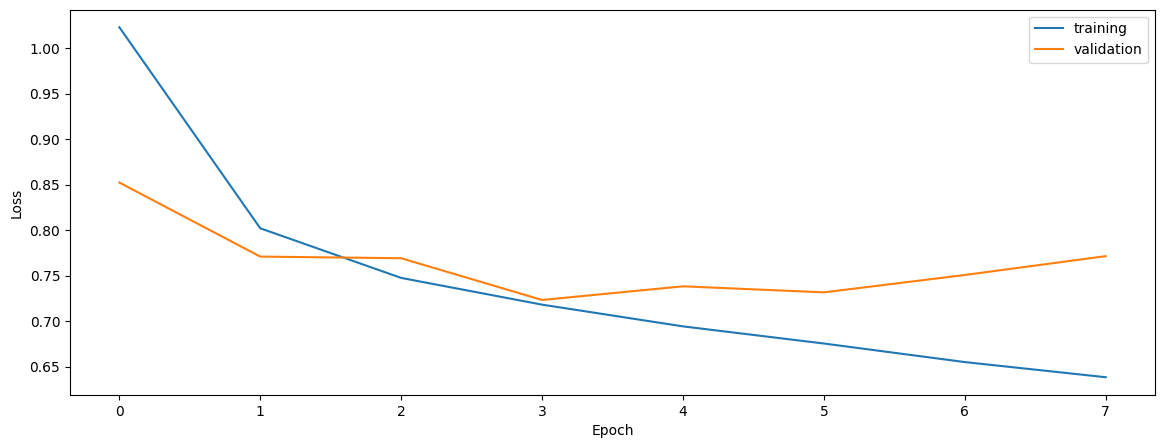

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.751927963888478
0.7449374997929863
0.7588429251993083


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.751927963888478
0.7449374997929863
0.7588429251993083


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7500251211012545
0.7573456950438798
0.7582778364749204


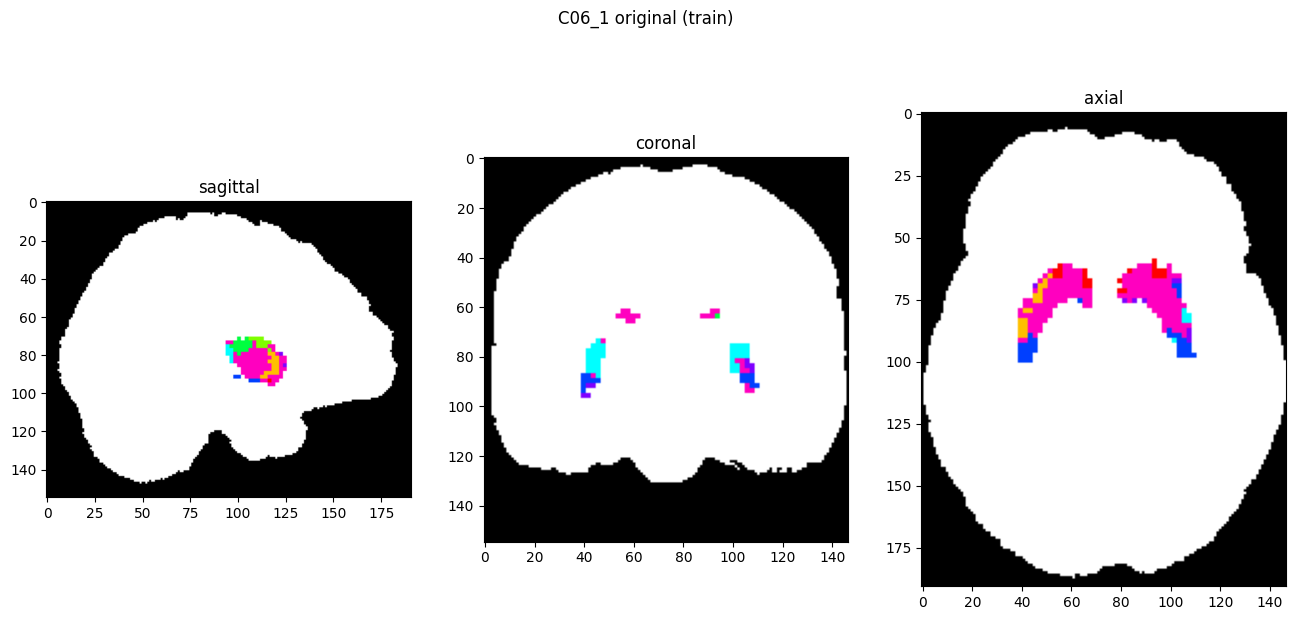

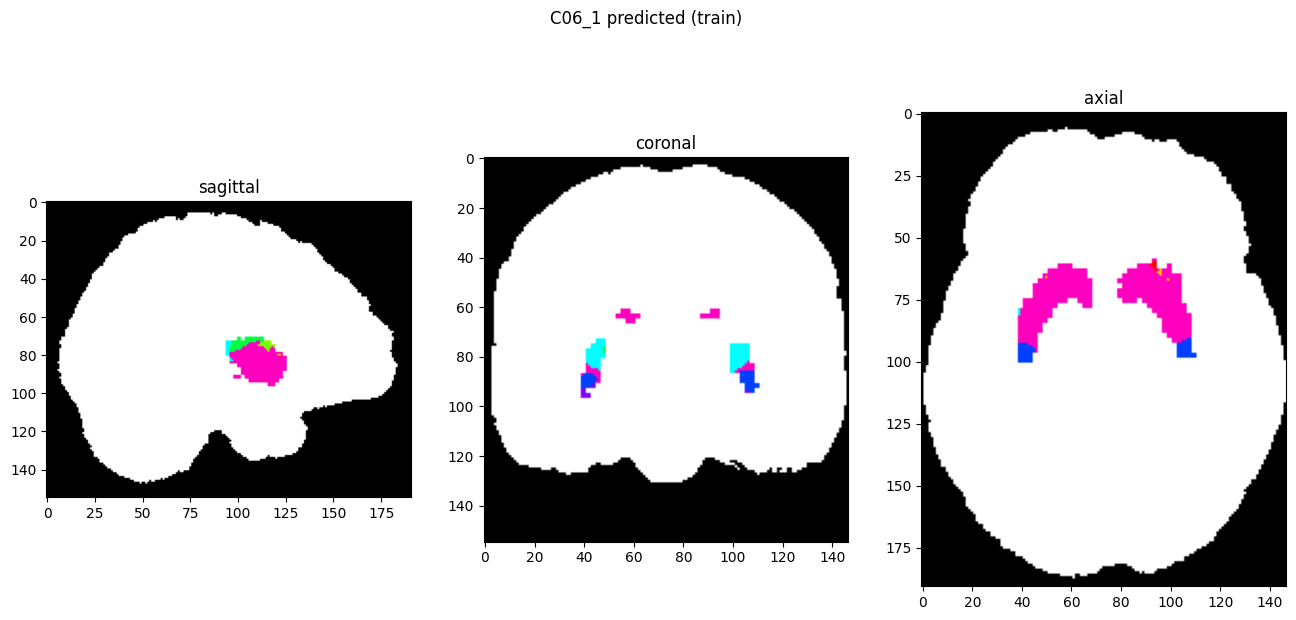

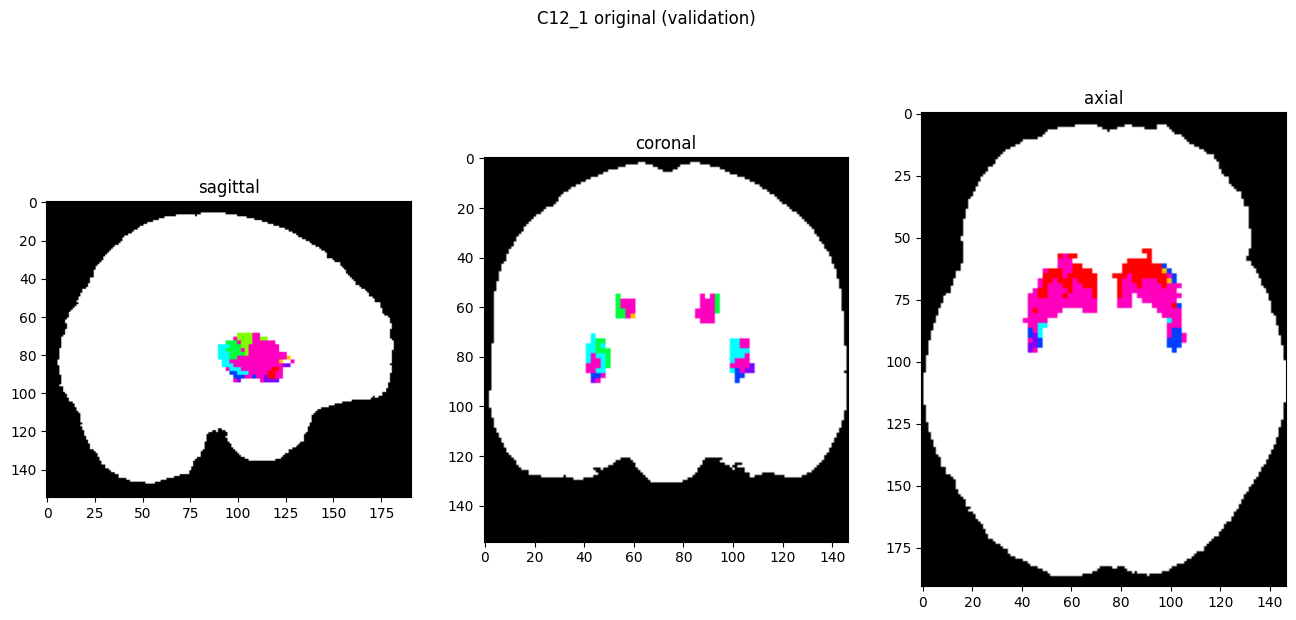

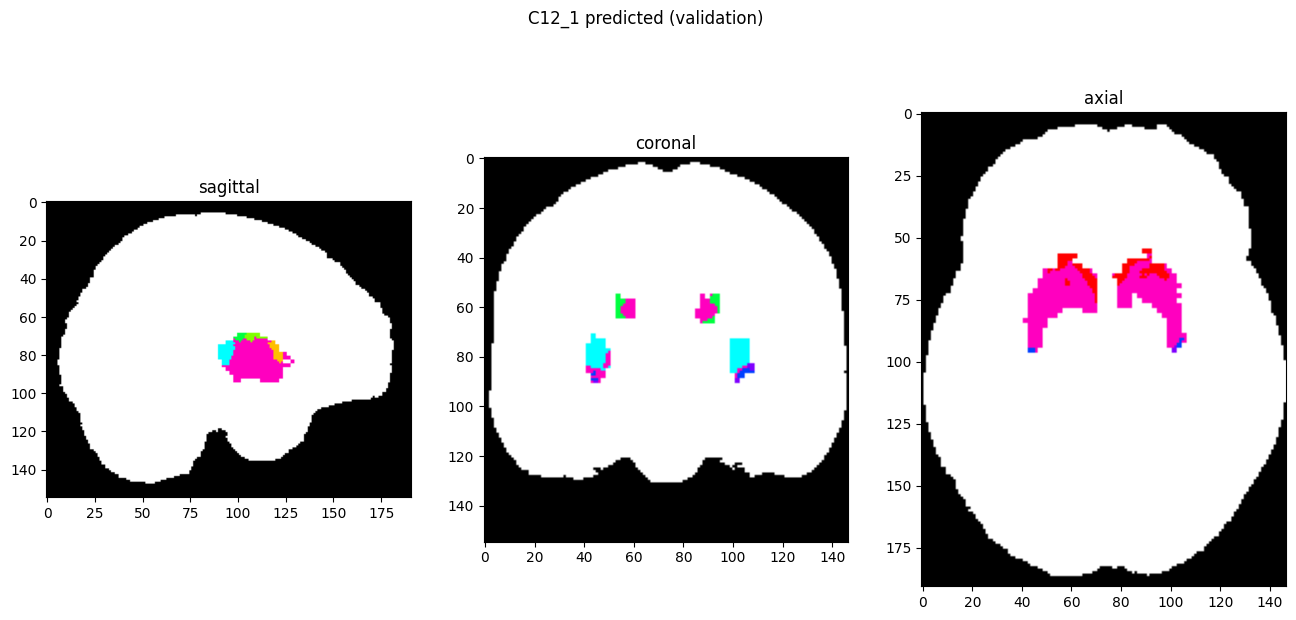

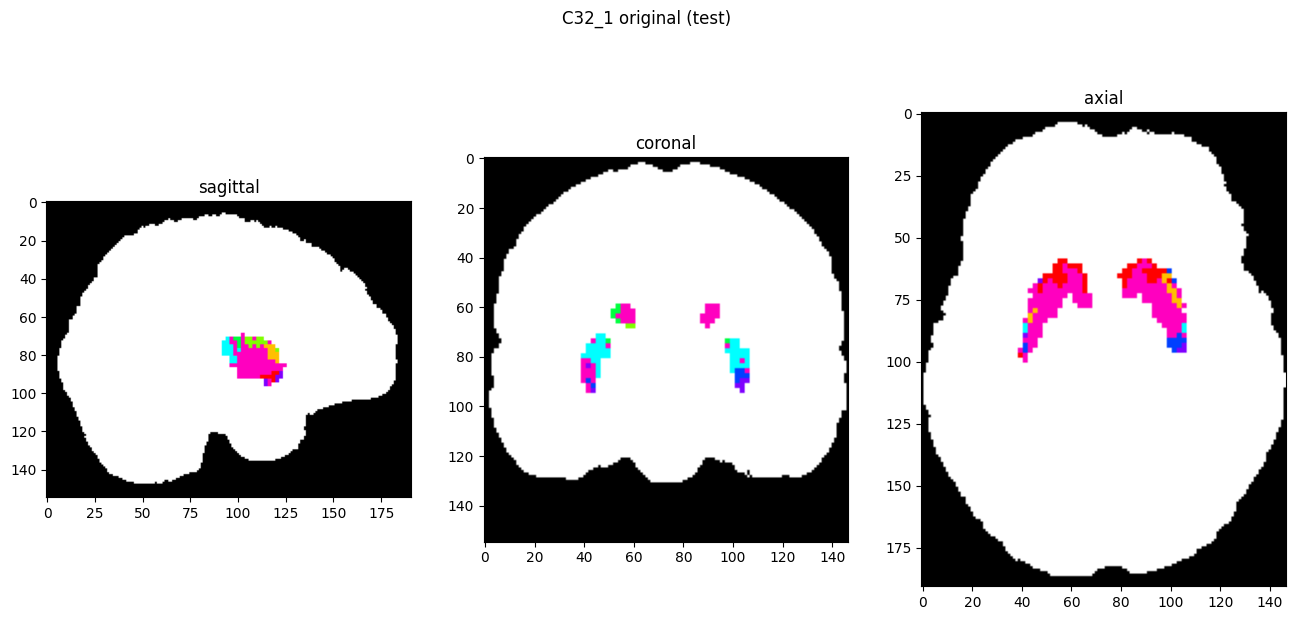

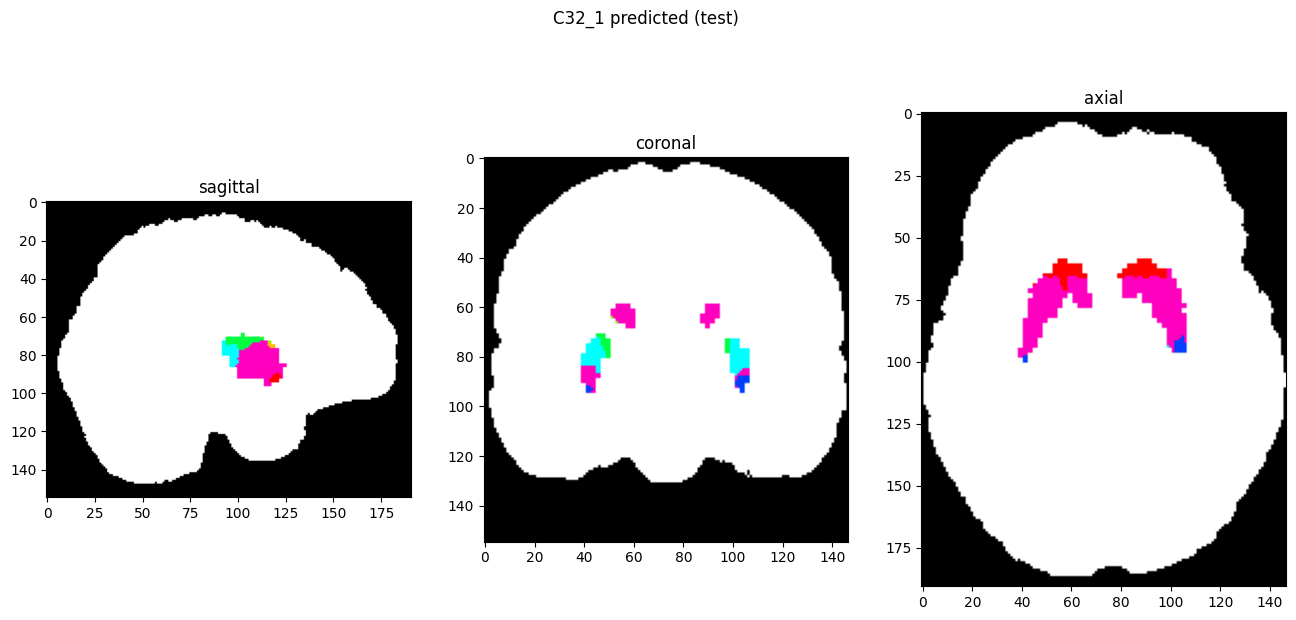

In [10]:
showResults(model, gen, threshold=0)